In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [17]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_175728\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print (f"Most recent date in the data set: {most_recent_date[0]}")

Most recent date in the data set: 2017-08-23


(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 [Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7'),
  Text(0, 8.0, '8')])

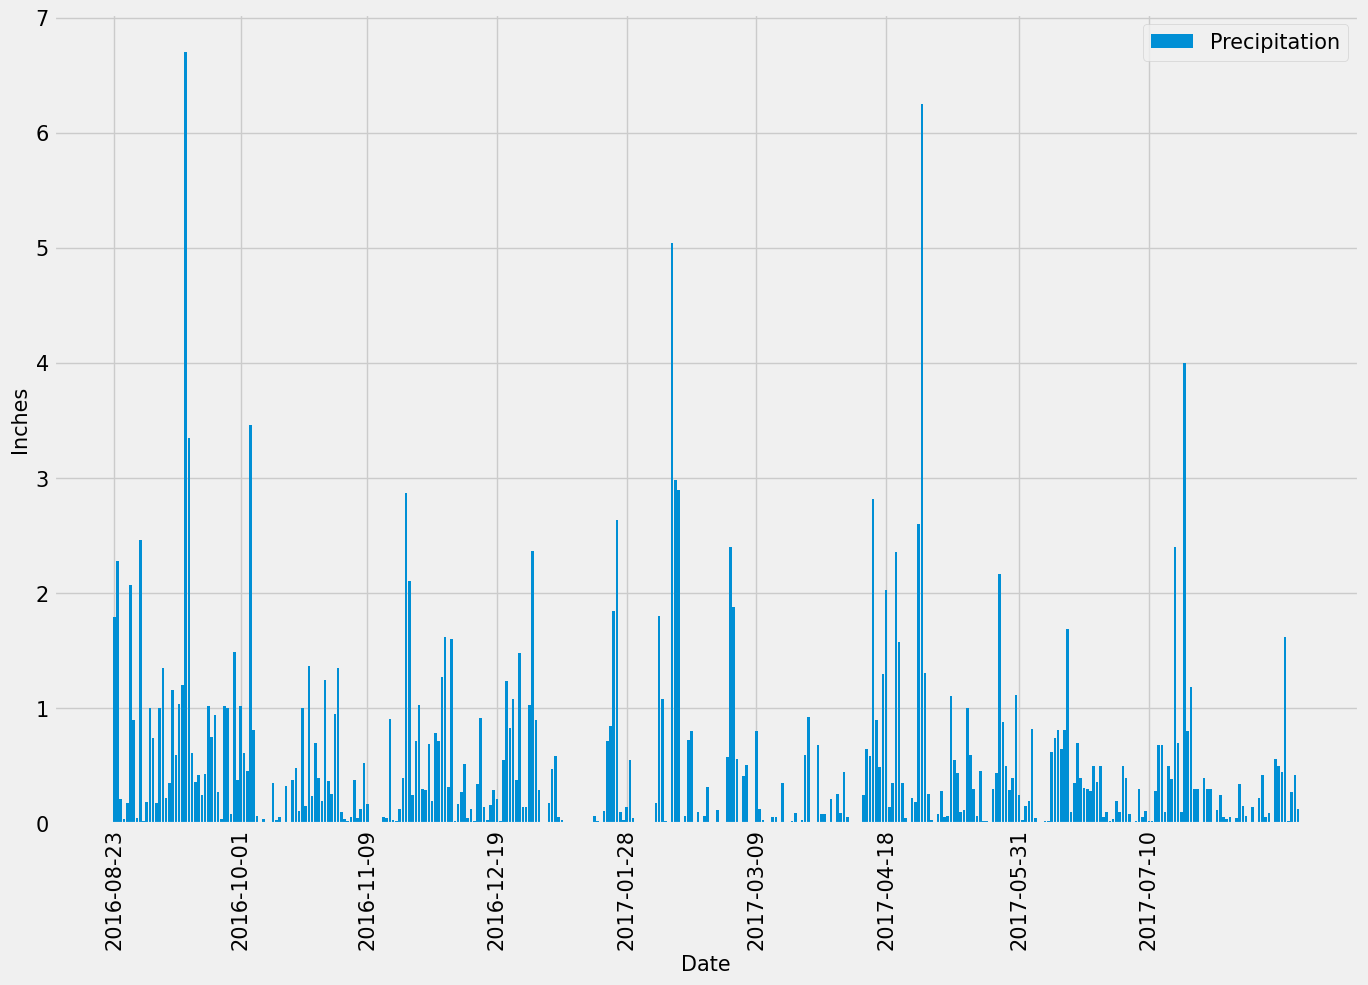

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(func.max(Measurement.date)).scalar()
# Calculate the date one year from the last date in data set.
date_one_year_ago_dt = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query_date = date_one_year_ago_dt.strftime("%Y-%m-%d")

last_year_precipitation = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= "2016-08-23").all()

last_year_precipitation

# Save the query results as a Pandas DataFrame. Explicitly set the column names
sorted_df = pd.DataFrame(last_year_precipitation, columns=['Date','Precipitation'])
sorted_df.head()

# Sort the dataframe by date
sorted_df.set_index('Date', inplace=True)
sorted_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15, 10))
plt.bar(sorted_df.index, sorted_df['Precipitation'])

plt.legend(['Precipitation'], loc="upper right",fontsize=15)

# set x location
xloc = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18','2017-05-31','2017-07-10'] 

# xticks
plt.xticks(xloc, rotation='vertical',fontsize=15)

# Labels
plt.xlabel('Date', fontsize=15)
plt.ylabel("Inches",fontsize=15)
plt.yticks(size=15)

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
locations = session.query(Measurement).group_by(Measurement.station).count()
print("{} stations.".format(locations))

9 stations.


In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temp_summary:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


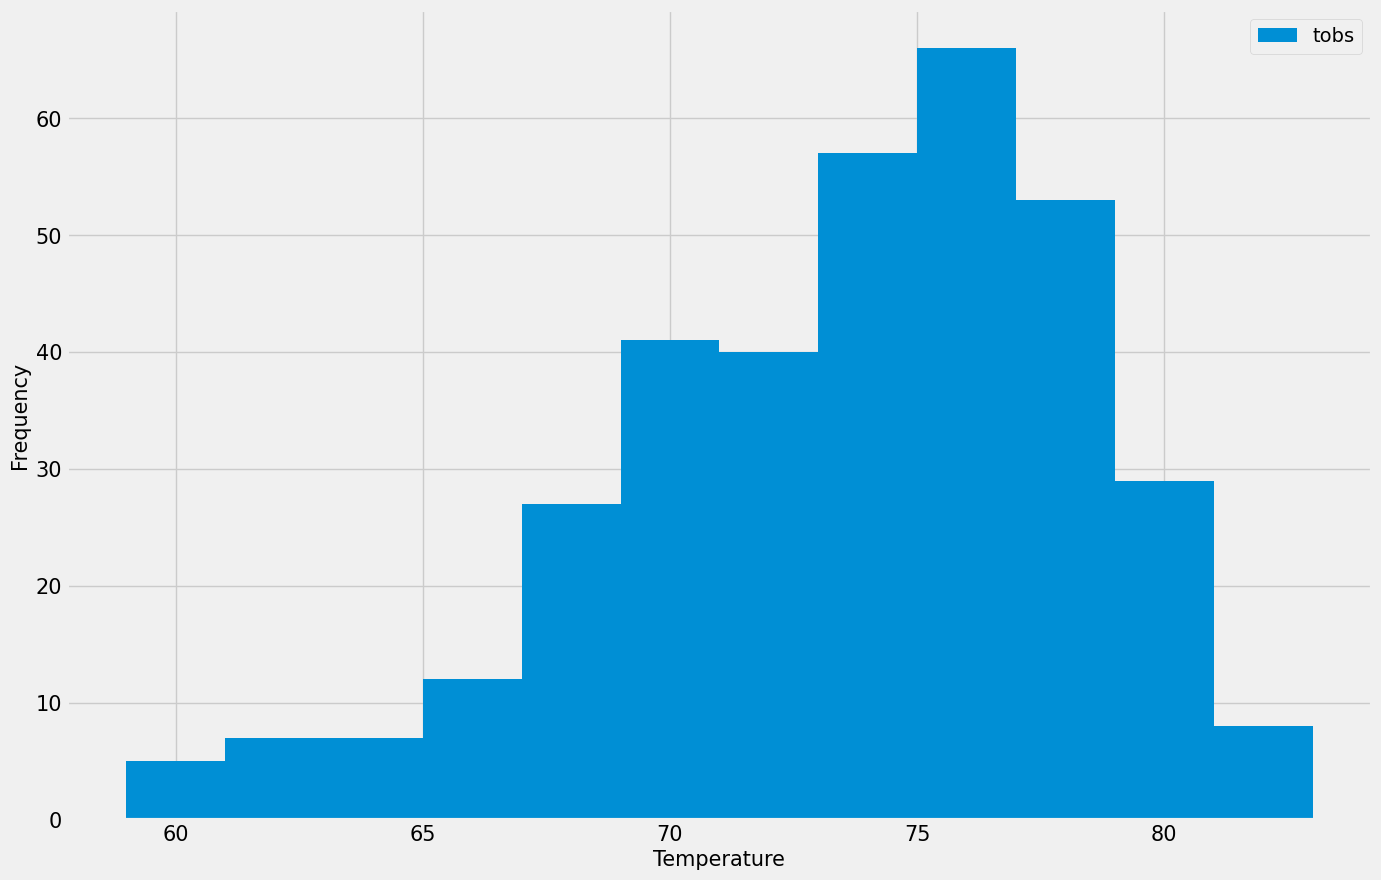

<Figure size 640x480 with 0 Axes>

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first()

results = session.query(Measurement.tobs).\
            filter(Measurement.date.between(query_date,last_date),\
                   Measurement.station == 'USC00519281').all()

plt.figure(figsize=(15,10))
plt.hist(np.ravel(results), bins=12)
plt.xlabel('Temperature',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend(['tobs'], loc = 'upper right')
plt.yticks(size=15)
plt.xticks(size=15)

plt.show()
plt.tight_layout()

# Close Session

In [24]:
# Close Session
session.close()